# RIOS: RainbowRio

<a href="https://colab.research.google.com/github/zhengxuan-luan/OSECC_RainbowRio/blob/main/Notebooks/RainbowRio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

```
RIOS, November 2022
SPDX-License-Identifier: Apache-2.0
```

## Team Members
|Name|Affiliation|IEEE Member|SSCS Member|
|:--:|:----------:|:----------:|:----------:|
|Yihai Zhang|RIOS Lab, Tsinghua-Berkeley Shenzhen Institute, Tsinghua University|No|No|
|Qiaowen Yang|RIOS Lab, Tsinghua-Berkeley Shenzhen Institute, Tsinghua University|No|No|
|Xinlai Wan|RIOS Lab, Tsinghua-Berkeley Shenzhen Institute, Tsinghua University|No|No|
|Chao Wang|RIOS Lab, Tsinghua-Berkeley Shenzhen Institute, Tsinghua University|No|No|
|Dongyu Zhang|RIOS Lab, Tsinghua-Berkeley Shenzhen Institute, Tsinghua University|No|No|
|Zhixuan Xu|RIOS Lab, Tsinghua-Berkeley Shenzhen Institute, Tsinghua University|No|No|
|Peichen Guo|RIOS Lab, Tsinghua-Berkeley Shenzhen Institute, Tsinghua University|No|No|
|Zhengxuan Luan|RIOS Lab, Tsinghua-Berkeley Shenzhen Institute, Tsinghua University|No|No|
|Mingzi Wang (Leader) <br/> Email: 1460779434@qq.com|RIOS Lab, Tsinghua-Berkeley Shenzhen Institute, Tsinghua University|No|No|
|Xinze Wang|RIOS Lab, Tsinghua-Berkeley Shenzhen Institute, Tsinghua University|No|No|
|Xiakai Pan|RIOS Lab, Tsinghua-Berkeley Shenzhen Institute, Tsinghua University|No|No|
|Zexin Fu|RIOS Lab, Tsinghua-Berkeley Shenzhen Institute, Tsinghua University|No|No|
|Yifei Zhu|RIOS Lab, Tsinghua-Berkeley Shenzhen Institute, Tsinghua University|No|No|
|Xi Wang|RIOS Lab, Tsinghua-Berkeley Shenzhen Institute, Tsinghua University|No|No|
|Lei Ren|RIOS Lab, Tsinghua-Berkeley Shenzhen Institute, Tsinghua University|No|No|
|WeiWei Chen|RIOS Lab, Tsinghua-Berkeley Shenzhen Institute, Tsinghua University|No|No|
|Zhangxi Tan (Advisor) <br />|RIOS Lab, Tsinghua-Berkeley Shenzhen Institute, Tsinghua University|No|No|

Welcome!
This notebook serves as an introduction to [RainbowRio](https://github.com/zhengxuan-luan/GreenRio_uncore): an open-source processor uncore subsystem exploration and evaluation platform. This platform automates the design flow end-to-end in Python-Colab environment and supports designing completely with open-source EDA tools(OpenLane).

**_Index Terms:_** open source, coherence, system on chip, cache, electronic design automation.

## Introduction
RainbowRio is developing a full-system, full-stack SoC exploration and evaluation platform, aimed at providing an open-source SoC platform for Open Source Community members. OrangeRio platfrom includes an tiny but well-established SoC, high-performance L1 data Cache and L1 instruction Cache with supporting MMU. OrangeRio Platform can be seamlessly matched with GreenRio high-performace RISC-V processor, which gives great convenience to those who want to develop applications on RISC-V environment. This project uses only open source tool set for simulation, synthesis and backend tools. The whole flow follows the OpenLane methodology and the platform environment is compatible with efabless/carvel methodology. RainbowRio enables architects to make useful insights into how to utilize this platform to construct their own processor systems, making use of this streamlined flow to achieve rapid design iteration. 
<br/><br/>

This project includes two part: cache and SoC. The Cache is a VIPT non-blocking high-performance cache which supports the conherence protocol for multi-cores and the AMO and FENCE instructions for operating system. It consists of eight banks and one store-buffer. In each bank, it has miss status handling register, line fill buffer, evict queue, snoop buffer,mesi table, tag ram and data ram. Before tape-out, this project can simulate multi-cores environment by instantiating two caches and one Snoop Control Unit(SCU) to show the correctness of coherence protocol in this cache. After tape-out, several chips will be connected to the SCU with the FPGA platform. The SoC part consists of all eseential part to boot a Linux operating system: an Uart, a GPIO, a testio(for debug), a PLIC, a CLINT and other components(like bus interconnect and timer). What's more, in order to achievewe design one EBI(external bus interface) to act as die-to-die ACE bus signal transmmter. This interface is completely compatible with [ACE](https://developer.arm.com/documentation/ihi0022/e/ACE-Protocol-Specification) bus, providing this system with cache coherence capacity cross dies. SCU is also provided to control LLC and communicate with each levels' cache. 

## Specification

### SoC diagram
![SoC diagram][soc_diagram_tag]

### Bus

GreenRio uses wishbone bus as on-chip bus.

|port   | description|
| :---: | :---------:|
|cyc	| indicates that a valid bus cycle is in progress. |
|stb	| chipselect: indicates a valid data transfer cycle. |
|we	    | indicates whether the current local bus cycle is a READ or WRITE cycle.|
|ack	| indicates the termination of a normal bus cycle by slave device.|
|sel    | select which byte is effective. | 
|wdata  | the data to be written to slave machine. |
|rdata  | read data responsed by slave machine. |
|addr   | indicates the target address to be read / written. |

See more detaild introduction in [WISHBONE SoC INterconnection Architecture for Portable IP Cores](https://cdn.opencores.org/downloads/wbspec_b4.pdf).

### CLINT (Core Local Interruptor)

#### Interface

|    IO    |       name         |     width      |             description                |
| :------: | :----------------- | :------------- | :------------------------------------- |
| output  | clint_core_tmr_irq_o | 1 | timer interrupt |
| output  | clint_core_soft_irq_o | 1 | software interrupt |
| input   | wbm_clint_cyc_i | 1 | |
| input   | wbm_clint_stb_i | 1 |  |
| input   | wbm_clint_addr_i | WB_AD_WIDTH |  |
| input   | wbm_clint_wdata_i | WB_DAT_WIDTH |  |
| input   | wbm_clint_we_i | 1 | 0:read <br> 1:write |
| input   | wbm_clint_sel_i | WB_DAT_WIDTH/8| |
| output  | clint_wbm_rdata_o | WB_DAT_WIDTH |  |
| output   | clint_wbm_ack_o | 1 |  |

#### Registers

|    register    |   address   |    description                |
| :------: | :---------- | :------------------- | 
| mtimecmp  | 0x0200_0000  | if mtime > mtimecmp, trigger machine timer interrupt |
| stimecmp  | 0x0200_0020  | if stime > stimecmp, trigger supervisor timer interrupt |
| mtime | 0x0200_0008 | count time (synchronous with core) |
| stime | 0x0200_0028 | count time (synchronous with core) |
| msip | 0x0200_0010 | if msip[0] is written 1, generate machine software interrupt |
| ssip | 0x0200_0030 | if ssip[0] is written 1, generate supervisor software interrupt |


### PLIC(Platform-Level Interrupt Controller)

#### Interface

|    IO    |       name         |     width      |             description                |
| :------: | :----------------- | :------------- | :------------------------------------- |
| output  | plic_core_ext_irq_o | 1 | external interrupt for core |
| input  | gpio_plic_irq_i | 1 | GPIO's interrupt instruction |
| input   | uart_plic_irq_i | 1 |UART's interrupt instruction |
| input   | wbm_plic_cyc_i | 1 | |
| input   | wbm_plic_stb_i | 1 |  |
| input   | wbm_plic_addr_i | WB_AD_WIDTH |  |
| input   | wbm_plic_wdata_i | WB_DAT_WIDTH |  |
| input   | wbm_plic_we_i | 1 | 0:read <br> 1:write |
| input   | wbm_plic_sel_i | WB_DAT_WIDTH/8| |
| output  | plic_wbm_rdata_o | WB_DAT_WIDTH |  |
| output   | plic_wbm_ack_o | 1 |  |

#### Registers

|    register    |   address   |    description                |
| :------: | :---------- | :------------------- | 
| uart_priority  | 0x0200_0100 | High priority interrupt can be issued first. |
| gpio_priority  | 0x0200_0104 |  |
| uart_ip | 0x0200_0108 | After one interrupt issued， its corresponding IP register rises, until core read interrupt interrupt source identification to pull down it. |
| gpio_ip | 0x0200_010c |  |
| irq_threshold | 0x0200_0110 | if interrupt priority is higher than that value, then interrupt can be issued. |
| irq_response | 0x0200_0114 | Core generates a read request for this register to response external interrupt, value is interrupt source's ID|
| irq_complete | 0x0200_0118 | After core handle present interrupt, it will write corresponding ID to this register to release corresponding gateway. |
| uart_en | 0x0200_011c | interrupt enable |
| gpio_en | 0x0200_0120 |  |

#### Peripheral devices and ID

|    devce    |   ID   |
| :------: | :---------- | 
| uart  | 1 | 
| gpio  | 2 | 

### GPIO

#### Interface
|    IO    |       name         |     width      |             description                |
| :------: | :----------------- | :------------- | :------------------------------------- |
| input   | wbm_gpio_cyc_i | 1 | |
| input   | wbm_gpio_stb_i | 1 |  |
| input   | wbm_gpio_addr_i | WB_AD_WIDTH |  |
| input   | wbm_gpio_wdata_i | WB_DAT_WIDTH |  |
| input   | wbm_gpio_e_i | 1 | 0:read <br> 1:write |
| input   | wbm_gpio_sel_i | WB_DAT_WIDTH/8| |
| output  | gpio_wbm_rdata_o | WB_DAT_WIDTH |  |
| output   | gpio_wbm_ack_o | 1 |  |
| output  | gpio_plic_irq_o | 1 |  |
| input   | gpio_in_i | 1 | | |
| output   | gpio_out_o | 1 | |


#### Registers
|    register    |   address   |    description         |
| :------: | :---------- | :------------------- | 
| GPIO_VALUE_ADDR  | 0x0200_0200 |  |
|  GPIO_INPUT_EN_ADDR | 0x0200_0204 | [0]: input enable (if input enable is off, GPIO is in output mode)<br> [1]: interrupt enable |
| GPIO_PORT_ADDR | 0x0200_0208 |  |

#### interrupt mechanism

If input_enable is on and an edge change is detected, triggering an interrupt.

### UART

#### interface

|    IO    |       name         |     width      |             description                |
| :------: | :----------------- | :------------- | :------------------------------------- |
| output  | uart_tx_o | 1 |  |
| input  | uart_rx_i | 1 |  |
| input   | wbm_uart_cyc_i | 1 | |
| input   | wbm_uart_stb_i | 1 |  |
| input   | wbm_uart_addr_i | WB_AD_WIDTH |  |
| input   | wbm_uart_wdata_i | WB_DAT_WIDTH |  |
| input   | wbm_uart_we_i | 1 | 0:read <br> 1:write |
| input   | wbm_uart_sel_i | WB_DAT_WIDTH/8| |
| output  | uart_wbm_rdata_o | WB_DAT_WIDTH |  |
| output   | uart_wbm_ack_o | 1 |  |
| output  | uart_plic_irq_o | 1 |  |

#### registers

|    register    |   address   |    description         |
| :------: | :---------- | :------------------- | 
| UART_TX_DATA_ADDR  | 0x0200_0300 | [7:0] is used <br> write to this address to fill the byte to be sent by  |
|  UART_RX_DATA_ADDR | 0x0200_0304 | [7:0] is used |
| UART_TX_CTRL_ADDR | 0x0200_0308 | [2] output interrupt enable <br> [1] 1 - two bit stop; 0 - one bit stop <br> [0] output enable |
| UART_RX_CTRL_ADDR | 0x0200_030c | [31:29] control interrupt watermark <br> [28:26] elements number in read_fifo <br> [2] input interrupt enable <br> [0] input enable |

#### message structure and interrupt mechanism

![][uart_message_structure_tag]

    baud rate is 115200
    Parity code is even parity check. For example: tx_data = 8'b11110000, parity_code = 1'b0
    The send buffer's depth and receive buffer's depth are both 8. 
    If the send buffer is full and still write to UART_TX_DATA_ADDR, the data in front slot will be discard.
    If the receive buffer is full and the position machine still sends message to UART, the data can't be received.
    If the elem number in output_fifo is less than tx_ctrl[18:16], trigger an interrupt. 
    If the elem number in input_fifo is less than rx_ctrl[18:16], trigger an interrupt.

### CRG

#### interface
|    IO    |       name         |     width      |             description                |
| :------: | :----------------- | :------------- | :------------------------------------- |
| input  |  async_reset_i  |  1  |   | 
| input  |  external_clk_i  |  1  |   |
| output |  global_clk_o    |   1  |   |
| output |  ebi_clk_o    |   1  |   |
| output |  core_reset_o  |   1  |   |
| output  |  perips_reset_o  |  1  |   | 
| input   | wbm_crg_cyc_i | 1 | |
| input   | wbm_crg_stb_i | 1 |  |
| input   | wbm_crg_addr_i | WB_AD_WIDTH |  |
| input   | wbm_crg_wdata_i | WB_DAT_WIDTH |  |
| input   | wbm_crg_we_i | 1 | 0:read <br> 1:write |
| input   | wbm_crg_sel_i | WB_DAT_WIDTH/8| |
| output  | crg_wbm_rdata_o | WB_DAT_WIDTH |  |

#### registers
|    register    |   address   |    description         |
| :------: | :---------- | :------------------- | 
| CRG_CTRL_ADDR  | 0x0200_0400 | [3:0] domain1\~4 clock enable <br> [7:4] domain1\~4 reset signal |
    Domain1: core, cache, clint, plic
    Domain2: uart
    Domain3: gpio
    Domain4: ebi
    Global config: testio, wb_interconnect, crg

### EBI

EBI is used for forwarding ACE bus transactions to off-chip part(SCU, L2 Cache etc).
#### diagram
![][ebi_diagram_tag]
#### Message structure
![][ebi_message_tag]
#### interface
|    IO    |       name         |     width      |             description                |
| :------: | :----------------- | :------------- | :------------------------------------- |
| ...  | l2_req_if_arready_o, <br>l2_req_if_arvalid_i <br> ...  |    | Port connected with Cache is same as SCU's | 
| input  |  ebi_i  |  16  |  accept the message from external ebi |
| output |  ebi_o    |   16  |  send messages to external ebi |
| output |  ebi_oen    |   16  | control the I/O mode of connected GPIO port  |
| input |  bus_switch_i  |   1  | When internal ebi accquire the ebi_bus, and external ebi needs to raise a request. External ebi needs to send a request through this channel to get the control of ebi_bus.  |
| output  |  bus_siwtch_o  |  1  | When internal ebi release the ebi_bus, and needs to raise a request(read or write). It needs to send a request through this channel to get the control of ebi_bus.  | 
|output | bus_switch_oen | 1 | control the I/O mode of bus_switch channel's connected GPIO port |


#### state transition

##### read process
`IDLE` -> `SEND_AR` -> `WAIT_R` -> `RECV_R` -> `RESP_R` -> `IDLE`

| original state | new state | transiting condition|
| :----: | :-------: | :-------: |
|IDLE | SEND_AR | Ebi is in idle, ready is high. Change state when the r_buffer has accepted the latest AR message. |
| SEND_AR | WAIT_R|  Use counter to tell the data to be sent cycle by cycle according to the protocol, and then enter WAIT_R (no bus control is released at this time) |
| WAIT_R | RECV_R | Start to read message from external ebi in cycle by cycle |
| RECV_R | RESP_R | Raise read channel's valid and wait cache to read data outside. |
| RESP_R | IDLE | When cache completes the reading process, state return IDLE. |

##### write process
`IDLE` -> `SEND_W` -> `WAIT_WACK` -> `CHECK_WACK` ->`IDLE`

| original state | new state | transiting condition|
| :----: | :-------: | :-------: |
|IDLE | SEND_W | Ebi is in idle, ready is high. Change state when the w_buffer has accepted the latest AW message. w_buffer has its own fsm, which controls its filling process. AW channel and W channel's message are both stored in w_buffer.  |
| SEND_W | WAIT_WACK|  Use counter to tell the data to be sent cycle by cycle according to the protocol, and then enter WAIT_WACK (no bus control is released at this time) |
| WAIT_WACK | CHECK_WACK | Start to read ack message. |
| CHECK_WACK | IDLE | Check whether writing has been handled successfully. If the data has been written to target address, return IDLE. |


##### snoop process
`IDLE` -> `RECV_SNP` -> `WAIT_SNP_REQ_READ` -> `WAIT_SNP_RESP` -> `SEND_SNP_RESP` ->`IDLE`

| original state | new state | transiting condition|
| :----: | :-------: | :-------: |
|IDLE | RECV_SNP |When the external ebi wants to raise a snoop request, it first has to accquire the bus control. Inner ebi changes state when the trx receive a start signal. The receive buffer starts to receive snoop request message |
| RECV_SNP | WAIT_SNP_REQ_READ | Output ports connected with cache snoop_request_ports abstract signal from receive buffer, valid signal rises, waiting cache to accept request. |
| WAIT_SNP_REQ_READ | WAIT_SNP_RESP | Snoop request is accepted by cache, waiting cache snoop response. |
| WAIT_SNP_RESP | SEND_SNP_RESP | The snoop_buffer has stored the response message from cache. Ebi starts to send this messages. |
| SEND_SNP_RESP | IDLE | After completing the sending process, ebi returns idle. (Because ebi acts as a slave in this process, it doesn't need to check ack) |

### TESTIO
#### interface 

| Signal Name | Width | IO     | Description                                             |
| ----------- | ----- | ------ | ------------------------------------------------------- |
| mem_if_req_valid    | 1     | input  | request valid signal |
| mem_if_req_ready    | 1     | output | request ready signal |
| mem_if_req_type     | 3     | input  | request type<br />'h0 : read <br />'h1 : write request |
| mem_if_req_tid      | 8     | input  | request id      |
| mem_if_req_paddr    | 32    | input  | request address |
| mem_if_req_data     | 32    | input  | request data, for write |
| mem_if_req_mask     | 4     | input  | request byte mask,for write |
| mem_if_resp_valid   | 1     | output | response valid  |
| mem_if_resp_ready   | 1     | input  | response ready  |
| mem_if_resp_type    | 3     | output | response type, same with request type |
| mem_if_resp_data    | 32    | output | response data  |
| mem_if_resp_tid     | 8     | output | response id    |
| ti_mod_i    | 2     | input  | testio tansport mode parameter,<br />[1:0] configure bit width:<br />00->1bit/single line,<br />01->8bits/8lines,<br />10->16bits/16lines,<br />11->32bits/32lines                         |
| ti_rstn_i   | 1     | input | rstn in|
| ti_int_i    | 1     | input  | testio interrupt from pad                               |
| ti_int_o    | 1     | output | testio interrupt to core                                       |
| ti_clk_i    | 1     | input | testio clk input signal from clk source, ti_clk_i == mem_if_clk |
| ti_clk_o    | 1     | output | testio clk output signal to pinmux/pad                  |
| ti_clk_oen  | 1     | output | testio clk output enable                                |
| ti_dat_o    | 32    | output | supply transport mode:<br />1bit, 8bit, 16bit and 32bit with ticsr register, to pinmux/pad                            |
| ti_dat_oen  | 32    | output | data output enable                                      |
| ti_dat_i    | 32    | input  | supply transport mode:<br />1bit, 8bit, 16bit and 32bit with ticsr register,from pinmux/pad                            |
#### TESTIO Protocol Example 
**TESTIO 1bit transport mode**  
![][testio_1bit_tag]

#### state machine description
State Description
1. TI_IDLE<br/>
Idle state, no transceiver, data bus is high, mem_if_valid and mem_if_type trigger state change.<br/>
2. TI_WR_SEND<br/>
Write mode send state, this mode sets the testio bus to output, and enters TI_WR_RCV_IDLE state after sending;<br/>
3. TI_WR_RCV_IDLE<br/>
The write mode waits for the START signal from the slave, the data bus is high, and after the slave Start signal is detected, it enters the TI_WR_RCV_ACK state;<br/>
4. TI_WR_RCV_ACK<br/>
Write mode detects ACK state, detects whether the slave responds to ACK signal correctly;<br/>
5. TI_WR_RCV_PARITY<br/>
Write mode detects the PARITY status of the ACK, and detects whether the slave is responding to the ACK signal correctly;<br/>
6. TI_WR_RCV<br/>
Write mode detects the STOP signal of the ACK, and detects whether the slave is finished responding to the ACK signal;<br/>
7. TI_RD_SEND<br/>
Read mode send state, this mode set testio bus as output, after sending into TI_RD_RCV_IDLE;<br/>
8. TI_RD_RCV_IDLE<br/>
Read mode wait for the slave to respond to START, the data bus is high, after detecting the slave Start signal, enter the TI_RD_RCV_ACK state;<br/>
9. TI_RD_RCV_ACK<br/>
Read mode detects ACK state, detects whether the slave response ACK signal is correct, if it is correct, it enters TI_RD_RCV state;<br/>
10. TI_RD_RCV<br/>
Read mode reads data status, this mode reads data, parity, and enters TI_RD_RESP after reading;<br/>
11. TI_RD_RESP<br/>
Read mode response to mem_if_resp state, this state will read the data to the mem_if_resp bus, and then enter TI_IDLE state after the transfer;<br/>
12. TI_ACK_ERR<br/>
The read/write mode enters this error mode when it encounters a data error, and enters the TI_IDLE state after the error mode sends an error signal;<br/>
#### TX and RX
![][txandrx_tag]

[txandrx_tag]: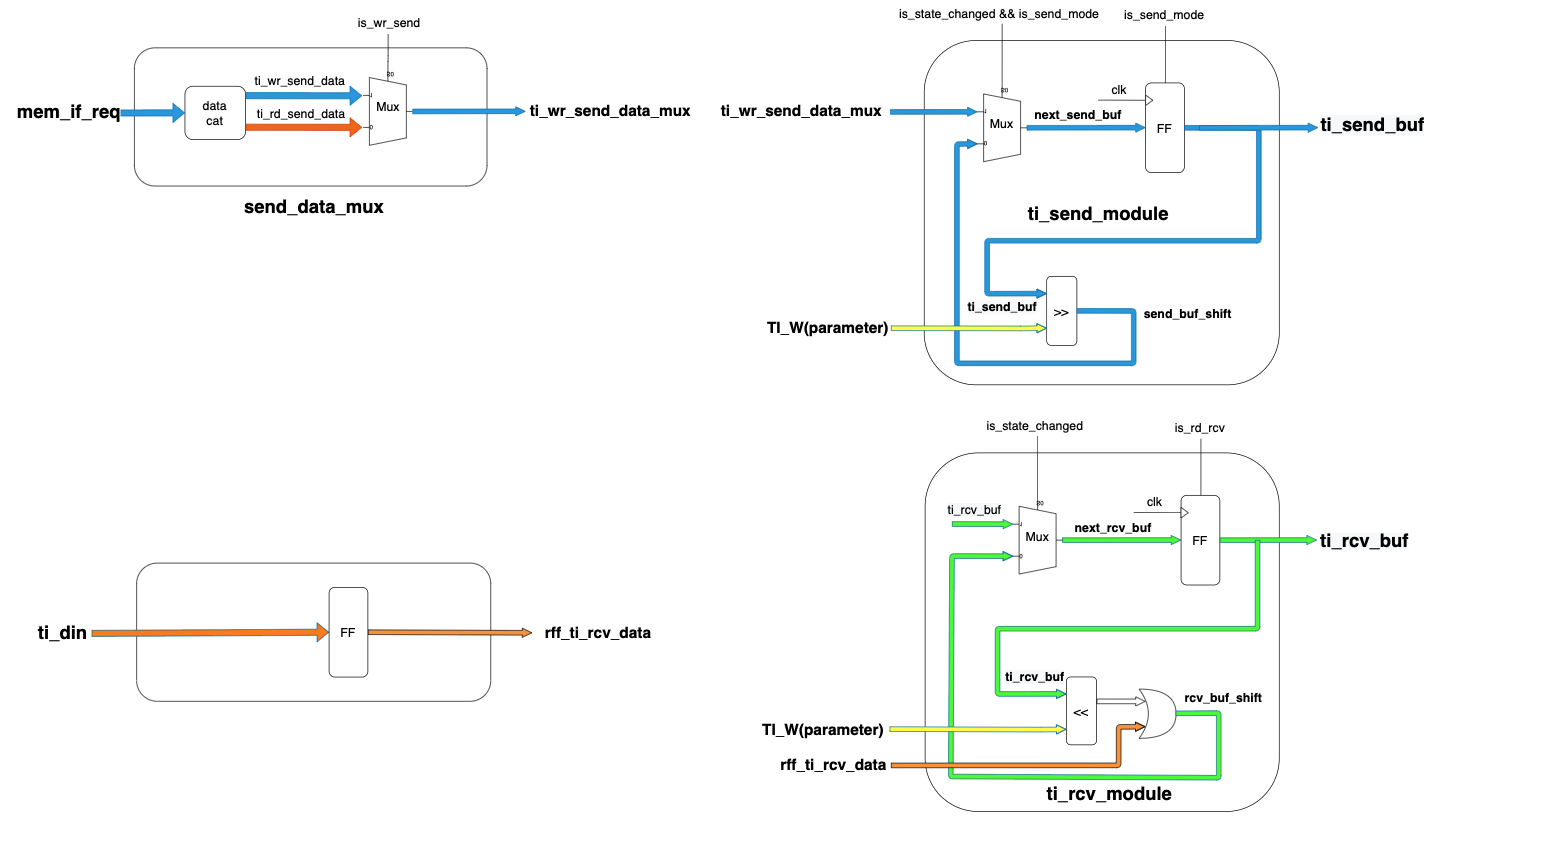

[testio_1bit_tag]: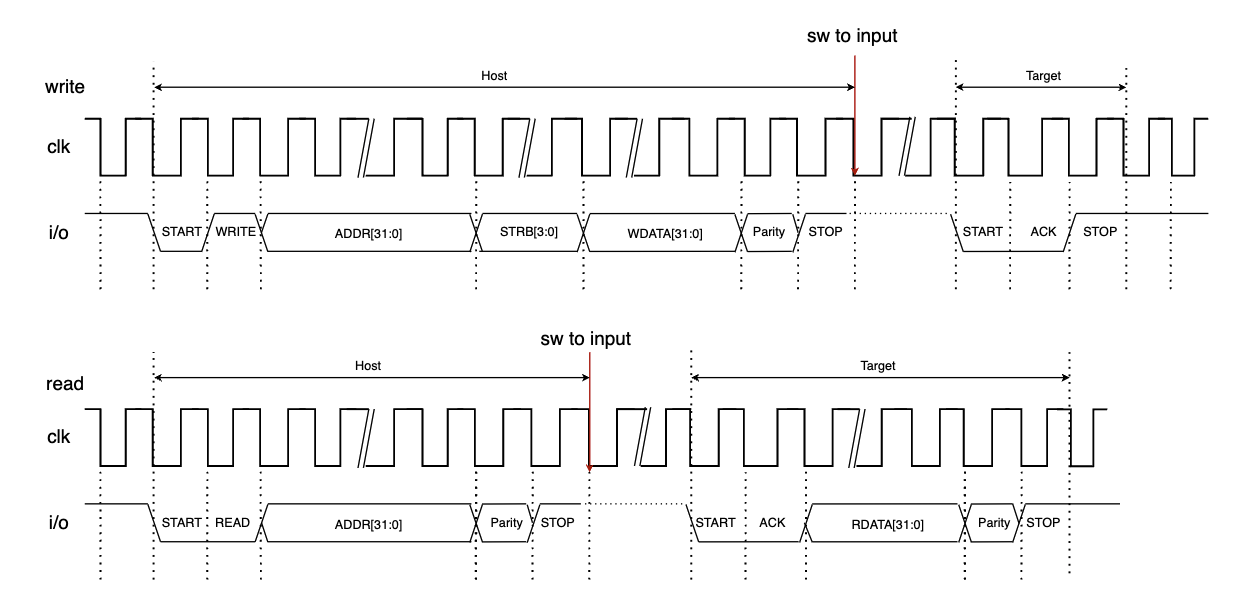
[soc_diagram_tag]: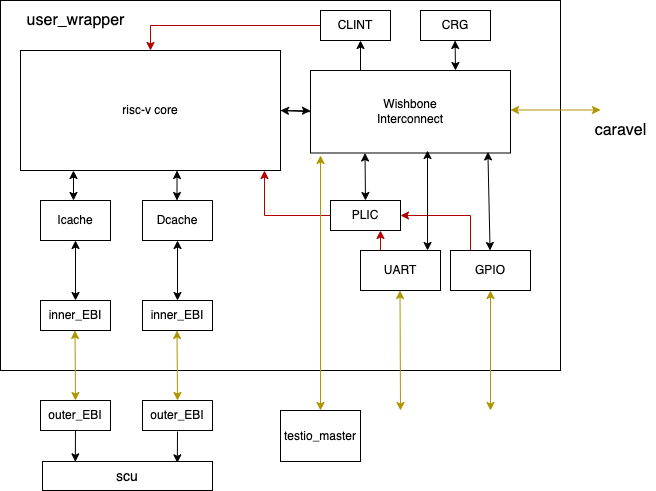

[uart_message_structure_tag]: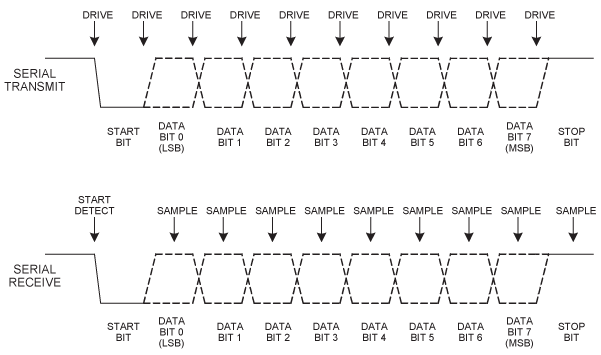

[ebi_diagram_tag]: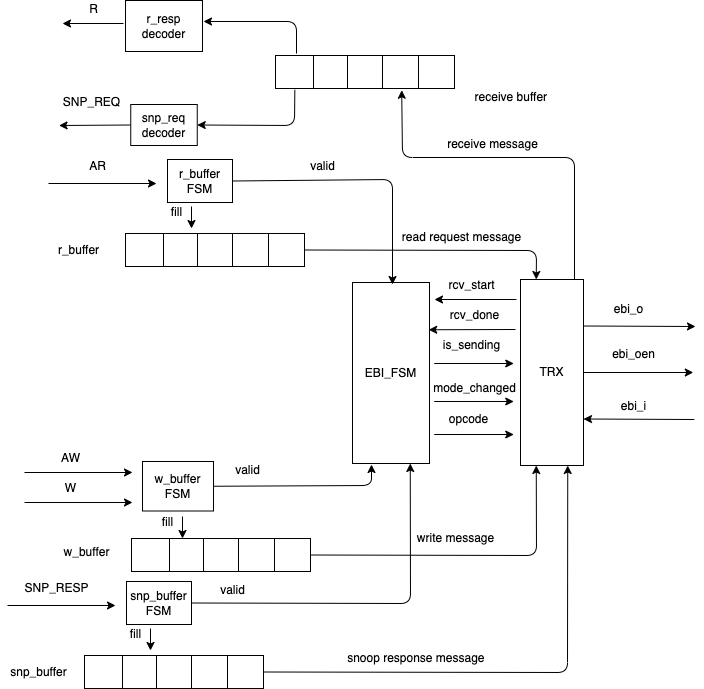

[ebi_message_tag]: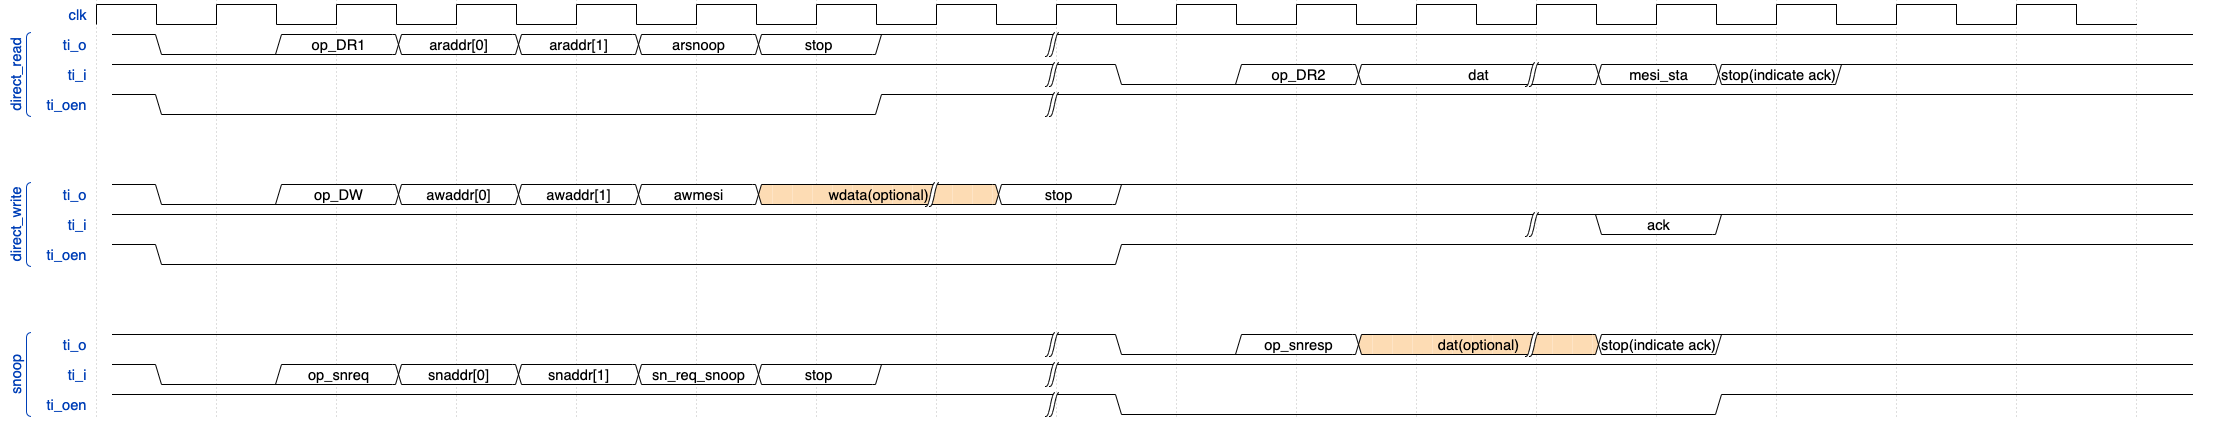


### Cache diagram

![][cache_tag]

### Cache bank diagram

![][cache_bank_tag]

### Cache features
* non-blocking cache

  * it can still accept requests when miss happens in the cache, because the mshr depth is greater than one, so it can also response the LSU out-of-order

* VIPT

  * it apply the virtual index and physical tag principle. at s0 stage, use virtual index to read all the way in tag and data ram. at s1 stage, mmu will send the physical tag of this request to cache, and compare with the output of tag ram. at s2 stage, if it is hit, response to LSU, if it is miss, send it to the MSHR.

* Multi-ports for LSU

  * to increase the performance of cache, it has multi-ports for the LSU requests. 

* Store-buffer

  * buffer store     : multiple stores may come into stb, th stb buffer them and send them to l1d bank at some timeout

  * store merge      : when different st req hit the same cache line, stb shoul merge them into one cache line, set its write mask, and send them to l1d bank as one write req

  * load bypass      : the st reqs in stb are commited, so it has latest data, when a load req comes, it has to search the stb for its data
 
  * eviction         : when the eviction condition is met, e.g. stb full, load partical hit, the stb need to evict one or all stb entries to l1d bank

  * coherence snoop  : snoop will search the stb, if there is a hit, it should wait for the stb entry evicted to the l1d bank and then start its coherence operation

* Multi-banks

  * this cache has eight banks, each bank has only one request port and it is only responsible for the corresponding address

* Support prefetch for fetch unit

  * cache line is 512bit, so in icache, multiple instructions can be fetched at one time, it is advantaged to the prefetch in fetch unit.

* Helical structure in data-ram

  * to decrease the power consumption, it use helical structure in the data ram, as shown in the below table, at s1 stage, the data ram should only be read out 512 bit data for four ways instead of 2048bit data by using this fancy idea.
  
  | addr                 | data_ram_0| data_ram_1| data_ram_2| data_ram_3|
  | -------------------- | --------- | --------- | --------- | --------- |
  | {set_idx,line_seg=0} | way0_seg0 | way1_seg0 | way2_seg0 | way3_seg0 |
  | {set_idx,line_seg=1} | way3_seg1 | way0_seg1 | way1_seg1 | way2_seg1 |
  | {set_idx,line_seg=2} | way2_seg2 | way3_seg2 | way0_seg2 | way1_seg2 |
  | {set_idx,line seg=3} | way1_seg3 | way2_seg3 | way3_seg3 | way0_seg3 |

* MSHR, Line fill buffer and Evict queue

  * MSHR is used to store the miss request and send them to the next level memory by AR channel
  * Line fill buffer is used to store the data send back from next level momory by R channel and refill them to tag and data ram
  * Evict queue is used to store the data evicted by the tag and data ram, and then write back to the next level memory
  * in this cache, the depth of these three buffers are configurable
 
* PLRU replace algorithm 

  * if the mapping structure of the cache is a W-way group connected mapping, that is, there are w cache lines in a set, tree PLRU will use the W - 1 bit to represent the binary tree of approximate access history order. According to the characteristics of the binary tree, tree PLRU divides the W cache lines into different blocks, and uses 0/1 to indicate the access time of the blocks.
 

### AMO / FENCE / FENCEI

#### AMO pipeline
* s0
    * flush store buffer
  * s1 
    * the store buffer is cleared
    * send the amo req by store req port directly to the cache bank
    * cache bank read tag ram, read data ram, read lst (like a load req)
  * s2
    * compare tag, check lst state
      * if hit(state E/M), goto **alu**
      * if miss, allocate mshr, ReadUnique, goto **refill**
  * refill
    * in mlfb refill fsm, goto **alu**
  * alu
    * do alu calculation, goto **write_resp**
  * write_resp
    * finish refill/store by new data into data ram
    * update tag ram, lst if needed
    * resp to lsu with old data

#### lr/sc pipeline


##### lr

  * s0
    * flush store buffer
  * s1
    * the store buffer is cleared
    * send the lr req by store req port directly to the cache bank
    * cache bank read tag ram, read data ram, read lst (like a load req)
  * s2
    * compare tag, check lst state
      * if hit(state E/M), goto **s3**
      * if miss, allocate mshr, ReadUnique, goto **refill**
  * s3
    * set reservation table in lst
    * resp to lsu with data
  * refill
    * in mlfb refill fsm, set reservation table in lst
    * finish refill/store by new data into data ram
    * update tag ram, lst if needed
    * resp to lsu with data

##### sc

  * s0
    * flush store buffer
  * s1
    * the store buffer is cleared
    * send the sc req by store req port directly to the cache bank
    * cache bank read tag ram, read lst (like a store req)
    * read reservation table
  * s2
    * compare tag, check lst state
      * if hit(state E/M, reservation table valid), goto **sc_succ**
      * else if miss goto **sc_fail**
  * sc_succ
    * clear reservation table in lst
    * resp 0 to lsu
    * write new data into data ram
  * sc_fail
    * clear reservation table in lst
    * resp 1 to lsu

#### fence
   separate the instructions before the fence and instructions after fence, fence will make the store instructions in store buffer be sent to banks as fast as possible
#### fencei
   fencei instruction is used to flush all the dirty cache line in the data ram and make them write back to the memory

### Conherence in chip

#### protocol

use MESI protocol, each cache line has one of four states, the cache lines' state is maintained at private cache's line state table(LST) or directory/snoopy filter in shared snoop control unit(SCU)

#### ACE channel

| channel             | signal              |    width    |   description            |
| ------------------- | ------------------- | ----------  | ---------------------    |
| ADDRESSREAD(AR)     | l2_req_if_arvalid   |      1      |                          |
|                     | l2_req_if_arready   |      1      |                          |
|                     | l2_req_if_ar_araddr | PADDR_WIDTH |                          |
|                     | l2_req_if_ar_arsnoop|      4      | snoop msg                |
| READ(R)             | l2_resp_if_rvalid   |      1      |                          |
|                     | l2_resp_if_rready   |      1      |                          |
|                     | l2_resp_if_r_dat    |      64     |                          |
|                     | l2_resp_if_r_mesi   |      2      |                          |
| ADDRESSWRITE(AW)    | l2_req_if_awvalid   |      1      |                          | 
|                     | l2_req_if_awready   |      1      |                          |         
|                     | l2_req_if_aw_awaddr | PADDR_WIDTH |                          |
|                     | l2_req_if_aw_mesi   |      2      | mesi type                |
| WRITE(W)            | l2_req_if_wvalid    |      1      |                          |
|                     | l2_req_if_wready    |      1      |                          |
|                     | l2_req_if_w_data    |      64     |                          |
| SNOOPREQ(SNREQ)     | l2_req_if_snvalid   |      1      |                          |
|                     | l2_req_if_snready   |      1      |                          |
|                     | l2_req_if_sn_addr   | PADDR_WIDTH |                          |
|                     | l2_req_if_sn_snoop  |      4      | snoop msg                |
| SNOOPRESP(SNRESP)   | l2_resp_if_snvalid  |      1      |                          |
|                     | l2_resp_if_snready  |      1      |                          |
|                     | l2_resp_if_has_data |      1      | whether resp has data    |
|                     | l2_resp_if_resp_data|      64     |                          |
|                     | l2_resp_if_sn_ack   |      1      | resp ack but not data    |

#### snoop msg
| snoop_type(4 bit)   | which channel can this type be appeared | discription
| ------------------- | --------------------------------------- | ----------- |
|  READ_DIRECTORY     | AR                                      | the req is ld, but it miss, it should send READ_DIRECTORY to the scu
|  WRITE_DIRECTORY    | AR                                      | the req is st, but it miss, it should send WRITE_DIRECTORY to the scu
|  READ_SNOOP         | SNREQ                                   | the req is ld, after sending the READ_DIRECTORY to scu, if the corresponding directory is M/E , send READ_SNOOP to the corresponding core
|  WRITE_SNOOP        | SNREQ                                   | the req is st, after sending the WRITE_DIRECTORY to scu, if the corresponding directory is M/E , send WRITE_SNOOP to the corresponding core           
|  INVALID            | SNREQ                                   | make the corresponding cache line INVALID
|  EXCLUSIVE          | SNREQ                                   | make the corresponding cache line EXCLUSIVE


### Snoop control unit(SCU) on FAGA
it has two state-machine in SCU, one is for AR channel, the next one is for AW channel.
#### AR state machine

##### diagram

![][ar_fsm_tag]

| AR_type(4 bit)                    | discription
| --------------------------        | ----------- |
|  AR_IDLE                          | idle for ar channel in scu
|  WAIT_ACK                         | after snooping to other cores, the scu should wait the ack from the snooped cores
|  R_REFILL_DATA_FROM_MEM           | the req from ar channel is DIRECTORYR , and refill the data from the memory        
|  W_REFILL_DATA_FROM_MEM           | the req from ar channel is DIRECTORYW , and refill the data from the memory        
|  W_SNOOP_WAIT_RESP                | after snooping to other cores, the scu should wait the response data from the snooped cores
|  W_SNOOP_WAIT_READY               | the req from ar channel is DIRECTORYW, and it should get the data from other cores and wait to snoop them
|  R_SNOOP_WAIT_RESP                | after snooping to other cores, the scu should wait the response data from the snooped cores
|  R_SNOOP_WAIT_READY               | the req from ar channel is DIRECTORYR, and it should get the data from other cores and wait to snoop them
|  R_REFILL_DATA_FROM_OTHER_CORE    | the req from ar channel is DIRECTORYR , and refill the data from other cores    
|  W_REFILL_DATA_FROM_OTHER_CORE    | the req from ar channel is DIRECTORYW , and refill the data from other cores    
|  AR_PENDING_UP                    | get the pending bit up  


#### AW state machine
##### diagram

![][aw_fsm_tag]

| AW_type(4 bit)      | discription
| ------------------- | -----------                                                                                                                  |
|  AW_IDLE            | idle for aw channel in scu                                                                                                   |
|  WRITE              | write back the data to memory                                                                                                |
|  AW_WAIT_SNOOP      | if the mesi state for evict data is shared, it should wait the snoop ready signal from other cores for snooping other cores  |
|  AW_SNOOP_WAIT_ACK  | after snooping to other cores, the scu should wait the ack from the snooped cores                                            |
|  AW_PENDING_UP      | get the pending bit up                                                                                                       |

[aw_fsm_tag]: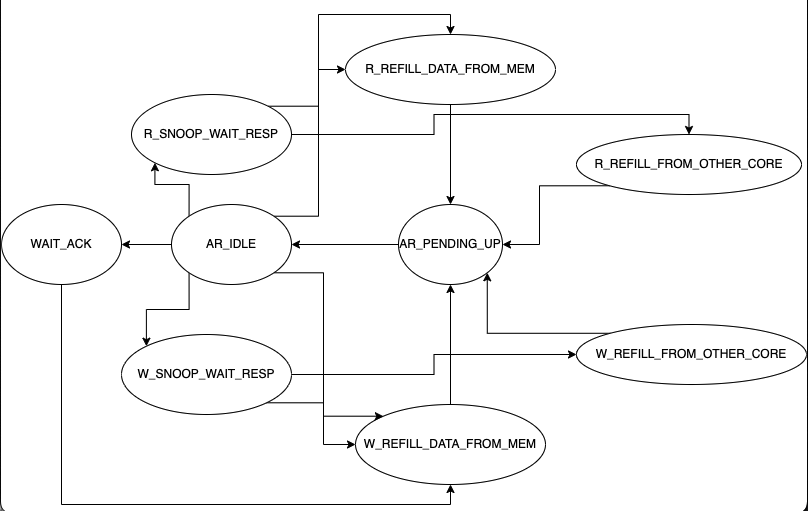
[ar_fsm_tag]: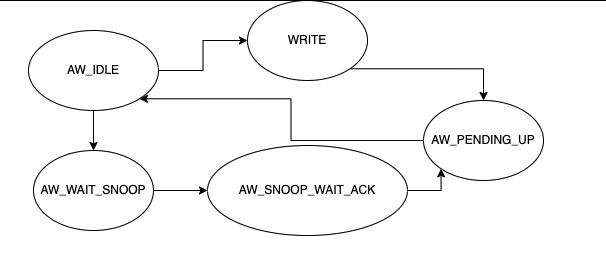
[cache_tag]: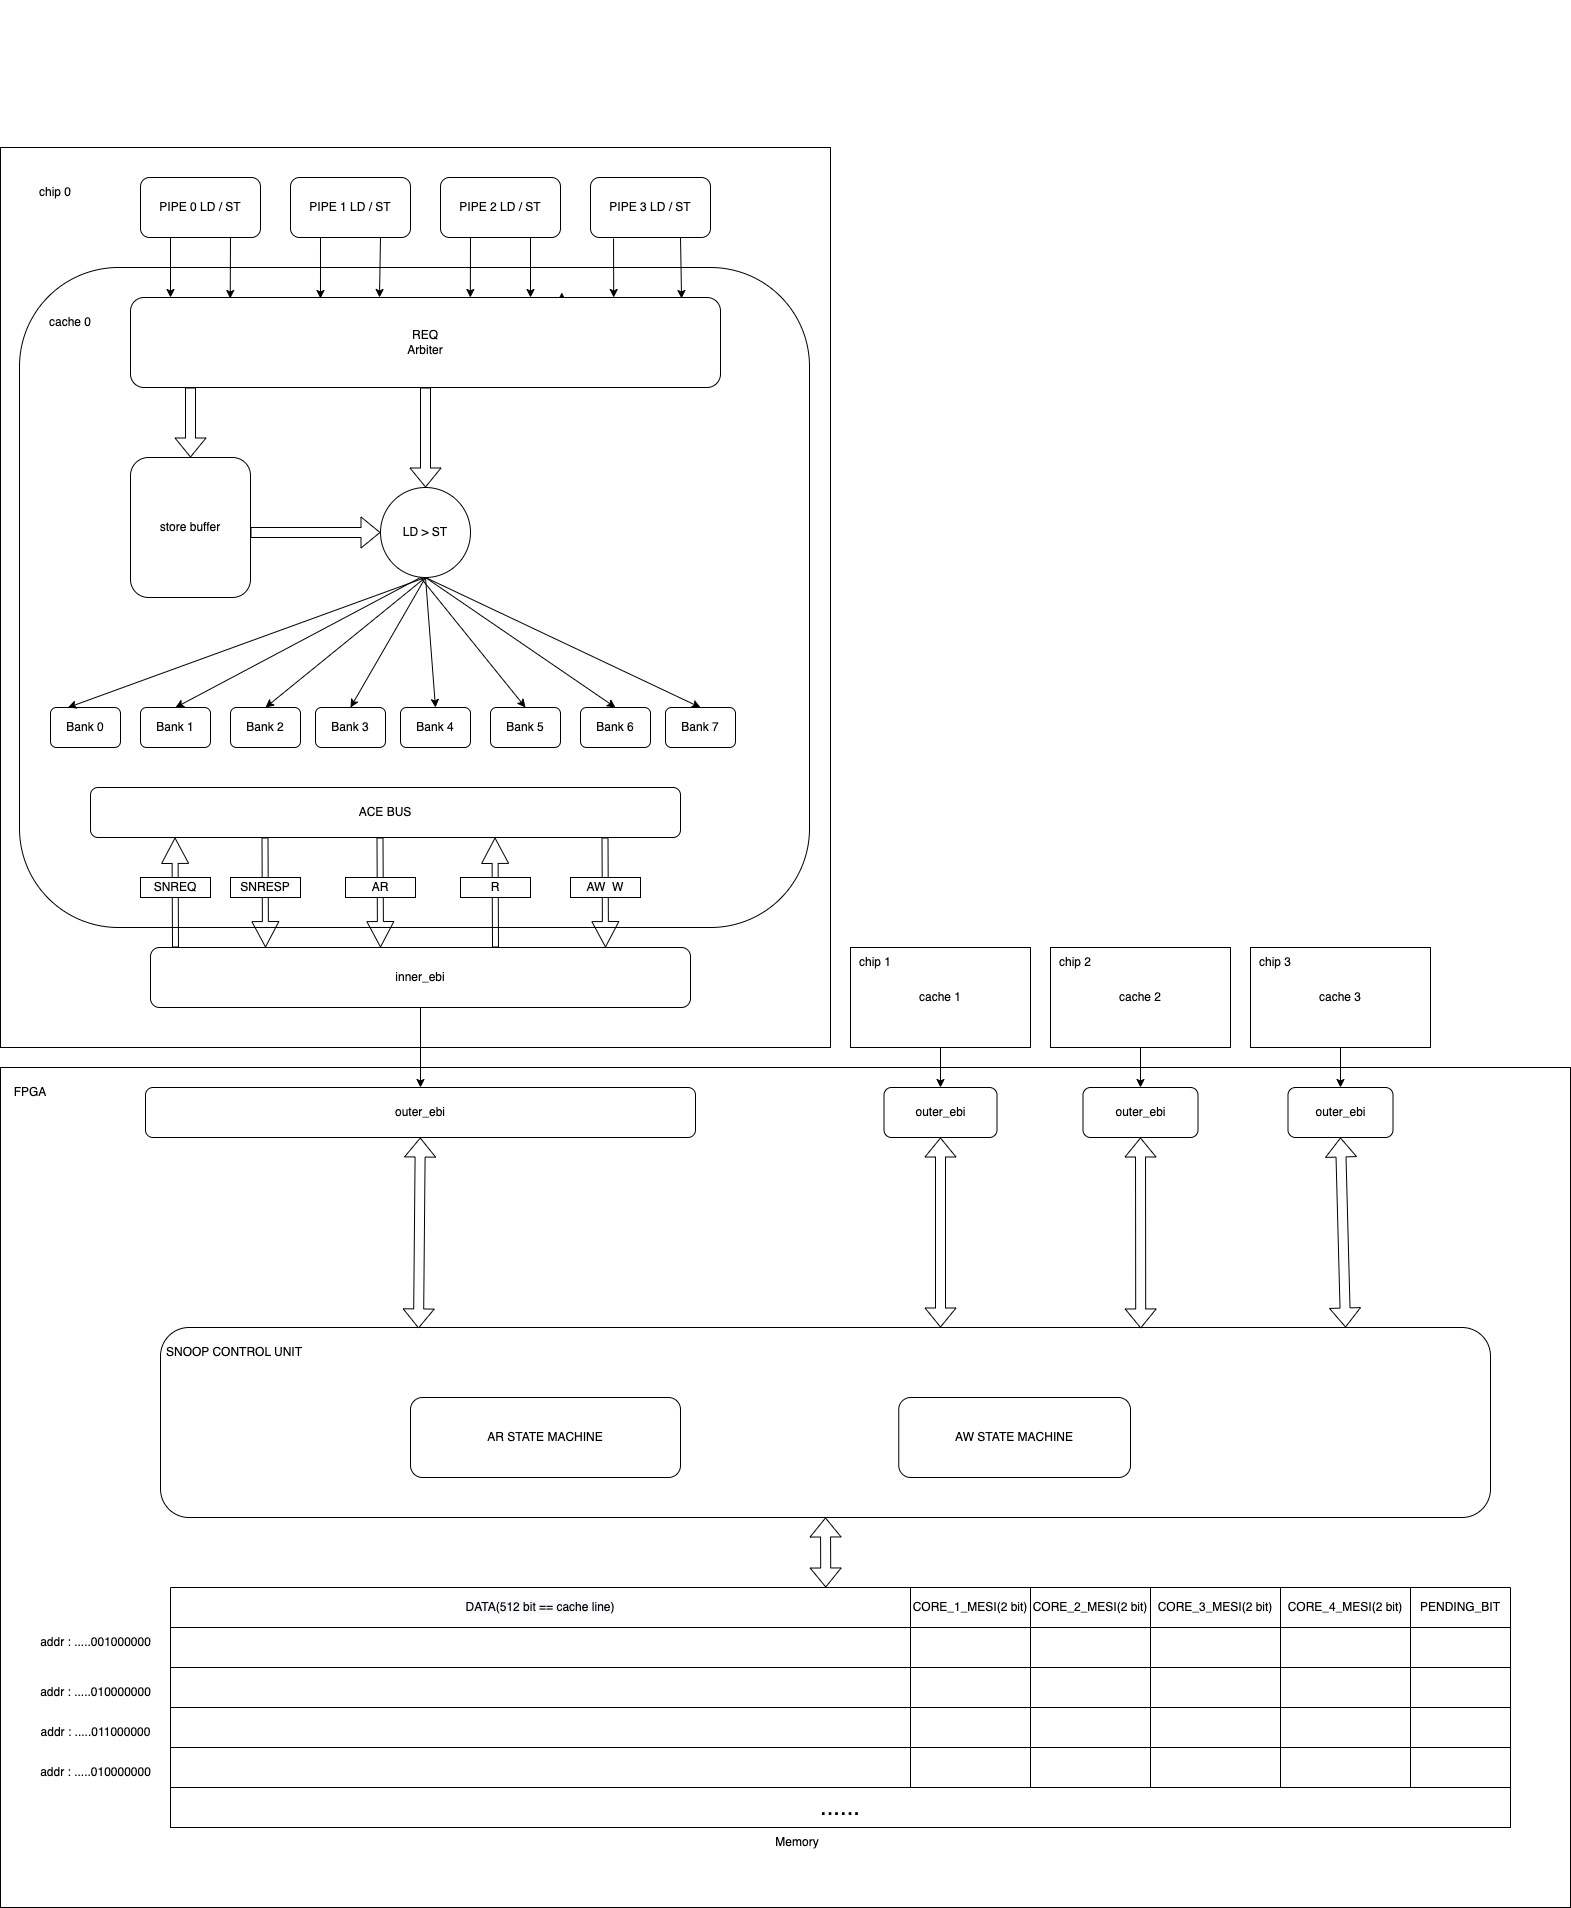

[cache_bank_tag]: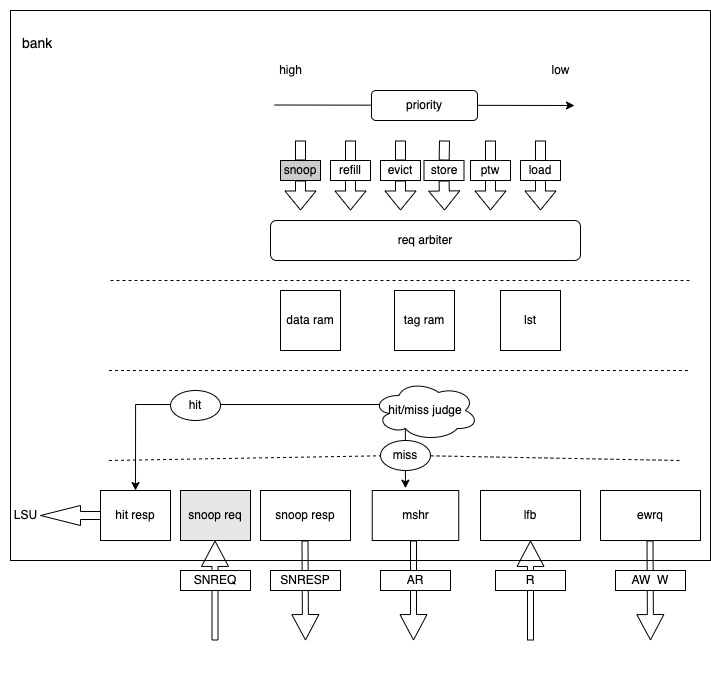

## RTL to GDSII Flow

### Install dependencies

In [ ]:
import os
import pathlib
import sys

!curl -Ls https://micro.mamba.pm/api/micromamba/linux-64/latest | tar -xvj bin/micromamba
conda_prefix_path = pathlib.Path('conda-env')
site_package_path = conda_prefix_path / 'lib/python3.7/site-packages'
sys.path.append(str(site_package_path.resolve()))
CONDA_PREFIX = str(conda_prefix_path.resolve())
PATH = os.environ['PATH']
LD_LIBRARY_PATH = os.environ.get('LD_LIBRARY_PATH', '')
%env CONDA_PREFIX={CONDA_PREFIX}
%env PATH={CONDA_PREFIX}/bin:{PATH}
%env LD_LIBRARY_PATH={CONDA_PREFIX}/lib:{LD_LIBRARY_PATH}
!bin/micromamba create --yes --prefix $CONDA_PREFIX
!echo 'python ==3.7*' >> {CONDA_PREFIX}/conda-meta/pinned
!bin/micromamba install --yes --prefix $CONDA_PREFIX \
                        --channel litex-hub \
                        --channel main \
                        open_pdks.sky130a \
                        magic \
                        openroad \
                        netgen \
                        yosys 
!bin/micromamba install --yes --prefix $CONDA_PREFIX \
                        --channel conda-forge \
                        tcllib gdstk pyyaml click

bin/micromamba
env: CONDA_PREFIX=/content/conda-env
env: PATH=/content/conda-env/bin:/opt/bin:/usr/local/nvidia/bin:/usr/local/cuda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/tools/node/bin:/tools/google-cloud-sdk/bin
env: LD_LIBRARY_PATH=/content/conda-env/lib:/usr/local/nvidia/lib:/usr/local/nvidia/lib64

                                           __
          __  ______ ___  ____ _____ ___  / /_  ____ _
         / / / / __ `__ \/ __ `/ __ `__ \/ __ \/ __ `/
        / /_/ / / / / / / /_/ / / / / / / /_/ / /_/ /
       / .___/_/ /_/ /_/\__,_/_/ /_/ /_/_.___/\__,_/
      /_/

Empty environment created at prefix: /content/conda-env

                                           __
          __  ______ ___  ____ _____ ___  / /_  ____ _
         / / / / __ `__ \/ __ `/ __ `__ \/ __ \/ __ `/
        / /_/ / / / / / / /_/ / / / / / / /_/ / /_/ /
       / .___/_/ /_/ /_/\__,_/_/ /_/ /_/_.___/\__,_/
      /_/

[+] 0.0s
[+] 0.1s
litex-hub/linux-64  ⣾  
litex-hub/noarch    ⣾

### Import Source Code

In [ ]:
!rm -rf GreenRio_uncore
!git clone https://github.com/zhengxuan-luan/GreenRio_uncore.git

Cloning into 'GreenRio_uncore'...
remote: Enumerating objects: 606, done.
remote: Counting objects: 100% (606/606), done.
remote: Compressing objects: 100% (424/424), done.
remote: Total 606 (delta 195), reused 567 (delta 161), pack-reused 0
Receiving objects: 100% (606/606), 4.06 MiB | 15.88 MiB/s, done.
Resolving deltas: 100% (195/195), done.


### SoC

#### Write configuration

In [ ]:
%%writefile clock.sdc
create_clock -name perips_clk -period 20.000 [get_ports {clk}] 
set_propagated_clock [get_clocks {clk}] 
create_clock -name testio_clk -period 20.000 [get_ports {testio_clk}] 
set_propagated_clock [get_clocks {testio_clk}] 


Writing clock.sdc


In [ ]:
%%writefile config.tcl
set ::env(DESIGN_NAME) soc_top

set ::env(VERILOG_FILES) "\ 
GreenRio_uncore/rtl/perips/on_chip/*.v \
GreenRio_uncore/rtl/perips/on_chip/perips_cfg.vh"

set ::env(CLOCK_PORT) "clk testio_clk"

set ::env(PL_RANDOM_GLB_PLACEMENT) 0
set ::env(CLOCK_PERIOD) {20.0}
set ::env(RT_MAX_LAYER) {met4} 
set ::env(RUN_FILL_INSERTION) 1 
set ::env(RUN_TAP_DECAP_INSERTION) 1 
set ::env(QUIT_ON_LVS_ERROR) "0" 
set ::env(QUIT_ON_MAGIC_DRC) "0" 
set ::env(QUIT_ON_NEGATIVE_WNS) "0" 
set ::env(QUIT_ON_SLEW_VIOLATIONS) "0" 
set ::env(QUIT_ON_TIMING_VIOLATIONS) "0" 
set ::env(SYNTH_MAX_FANOUT) 20 
set ::env(RUN_CVC) 0 
set ::env(GRT_MAX_DIODE_INS_ITERS) 5 

set ::env(SDC_FILE) "./clock.sdc" 
set ::env(BASE_SDC_FILE) "./clock.sdc" 

# set ::env(FP_SIZING) absolute
# set ::env(DIE_AREA) "0 0 850 850"
set ::env(FP_CORE_UTIL) 23
set ::env(PL_TARGET_DENSITY) 0.25
set ::env(SYNTH_STRATEGY) "AREA 3"
set ::env(FP_PDN_HORIZONTAL_HALO) 6
set ::env(FP_PDN_VERTICAL_HALO) 6

# set ::env(DIODE_INSERTION_STRATEGY) 4

# disable klayout because of https://github.com/hdl/conda-eda/issues/175
set ::env(RUN_KLAYOUT) 0
# disable CVC because of https://github.com/hdl/conda-eda/issues/174
set ::env(RUN_CVC) 0

set ::env(PL_RESIZER_TIMING_OPTIMIZATIONS) 1
# set ::env(PL_RESIZER_HOLD_SLACK_MARGIN) 0
# set ::env(PL_RESIZER_SETUP_SLACK_MARGIN) 0
set ::env(GLB_RESIZER_TIMING_OPTIMIZATIONS) 1

# set ::env(SYNTH_READ_BLACKBOX_LIB) 1
# set ::env(VERILOG_FILES_BLACKBOX) "\
#     GreenRio_uncore/rtl/perips/on_chip/sky130_fd_sc_hd.v \
# 	"
# set ::env(EXTRA_LEFS) "GreenRio_uncore/rtl/macros/lef/sky130_fd_sc_hd.lef"
# set ::env(EXTRA_GDS_FILES) "GreenRio_uncore/rtl/macros/gds/sky130_fd_sc_hd.gds"

Writing config.tcl


### Run OpenLane Flow

In [ ]:
# !rm -rf OpenLane                        
!git clone --depth=1 https://github.com/The-OpenROAD-Project/OpenLane
import os
import pathlib
OPENLANE_ROOT=str(pathlib.Path('OpenLane').resolve())
PATH=os.environ['PATH']
%env PDK_ROOT={CONDA_PREFIX}/share/pdk
%env PDK=sky130A
%env STD_CELL_LIBRARY=sky130_fd_sc_hd
%env STD_CELL_LIBRARY_OPT=sky130_fd_sc_hd
%env TCLLIBPATH={CONDA_PREFIX}/lib/tcllib1.20
%env OPENLANE_ROOT={OPENLANE_ROOT}
%env PATH={PATH}:{OPENLANE_ROOT}:{OPENLANE_ROOT}/scripts
%env OPENLANE_LOCAL_INSTALL=1
!flow.tcl -design . -ignore_mismatches
%mkdir openlane_soc
%mv runs/* ./openlane_soc

Cloning into 'OpenLane'...
remote: Enumerating objects: 553, done.
remote: Counting objects: 100% (553/553), done.
remote: Compressing objects: 100% (474/474), done.
remote: Total 553 (delta 77), reused 319 (delta 28), pack-reused 0
Receiving objects: 100% (553/553), 9.77 MiB | 39.38 MiB/s, done.
Resolving deltas: 100% (77/77), done.
env: PDK_ROOT=/content/conda-env/share/pdk
env: PDK=sky130A
env: STD_CELL_LIBRARY=sky130_fd_sc_hd
env: STD_CELL_LIBRARY_OPT=sky130_fd_sc_hd
env: TCLLIBPATH=/content/conda-env/lib/tcllib1.20
env: OPENLANE_ROOT=/content/OpenLane
env: PATH=/content/conda-env/bin:/opt/bin:/usr/local/nvidia/bin:/usr/local/cuda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/tools/node/bin:/tools/google-cloud-sdk/bin:/content/OpenLane:/content/OpenLane/scripts
env: OPENLANE_LOCAL_INSTALL=1
OpenLane ff85171cfb10dc44911db7a62cc2d86f03807756
All rights reserved. (c) 2020-2022 Efabless Corporation and contributors.
Available under the Apache License, version 2.0. S

### Display layout

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


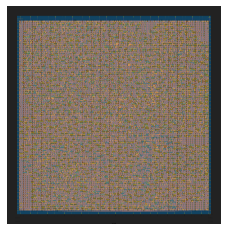

In [ ]:
!pip install cairosvg
!pip install matplotlib
import pathlib
import gdstk
import IPython.display
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cairosvg

gdss = sorted(pathlib.Path('openlane_soc').glob('*/results/final/gds/*.gds'))
library = gdstk.read_gds(gdss[-1])
top_cells = library.top_level()
top_cells[0].write_svg('soc_gds.svg')
cairosvg.svg2png(url='soc_gds.svg', write_to='soc_gds.png',dpi=200)
gds_png = mpimg.imread('soc_gds.png')
plt.imshow(gds_png)
plt.axis('off')
plt.show()

### Dump flow report

In [ ]:
import pandas as pd
import pathlib

pd.options.display.max_rows = None
final_summary_reports = sorted(pathlib.Path('openlane_soc').glob('*/reports/metrics.csv'))
df = pd.read_csv(final_summary_reports[-1])
df.transpose()

,0
design,/content
design_name,soc_top
config,RUN_2022.11.21_16.28.54
flow_status,flow completed
total_runtime,0h16m1s0ms
routed_runtime,0h8m10s0ms
(Cell/mm^2)/Core_Util,93466.605833
DIEAREA_mm^2,0.310922
CellPer_mm^2,21497.319342
OpenDP_Util,23.66


### Cache

#### Write configuration

In [13]:
%%writefile config.tcl
set ::env(DESIGN_NAME) rvh_l1d_bank

set ::env(VERILOG_FILES) "\ 
GreenRio_uncore/rtl/cache/on_chip/*.v"

set ::env(CLOCK_PORT) "clk"

set ::env(PL_RANDOM_GLB_PLACEMENT) 0
set ::env(CLOCK_PERIOD) {20.0}
set ::env(RT_MAX_LAYER) {met4} 
set ::env(RUN_FILL_INSERTION) 1 
set ::env(RUN_TAP_DECAP_INSERTION) 1 
# set ::env(QUIT_ON_LVS_ERROR) "0" 
# set ::env(QUIT_ON_MAGIC_DRC) "0" 
# set ::env(QUIT_ON_NEGATIVE_WNS) "0" 
# set ::env(QUIT_ON_SLEW_VIOLATIONS) "0" 
# set ::env(QUIT_ON_TIMING_VIOLATIONS) "0" 
# set ::env(SYNTH_MAX_FANOUT) 20 
# set ::env(RUN_CVC) 0 
# set ::env(GRT_MAX_DIODE_INS_ITERS) 5 


# set ::env(FP_SIZING) absolute
# set ::env(DIE_AREA) "0 0 850 850"
set ::env(FP_CORE_UTIL) 20
set ::env(PL_TARGET_DENSITY) 0.21
set ::env(SYNTH_STRATEGY) "AREA 0"



# set ::env(DIODE_INSERTION_STRATEGY) 4

# disable klayout because of https://github.com/hdl/conda-eda/issues/175
set ::env(RUN_KLAYOUT) 0
# disable CVC because of https://github.com/hdl/conda-eda/issues/174
set ::env(RUN_CVC) 0

# set ::env(PL_RESIZER_TIMING_OPTIMIZATIONS) 1
# set ::env(GLB_RESIZER_TIMING_OPTIMIZATIONS) 1



Writing config.tcl


#### Run OpenLane flow

In [14]:
import os
import pathlib
OPENLANE_ROOT=str(pathlib.Path('OpenLane').resolve())
PATH=os.environ['PATH']
%env PDK_ROOT={CONDA_PREFIX}/share/pdk
%env PDK=sky130A
%env STD_CELL_LIBRARY=sky130_fd_sc_hd
%env STD_CELL_LIBRARY_OPT=sky130_fd_sc_hd
%env TCLLIBPATH={CONDA_PREFIX}/lib/tcllib1.20
%env OPENLANE_ROOT={OPENLANE_ROOT}
%env PATH={PATH}:{OPENLANE_ROOT}:{OPENLANE_ROOT}/scripts
%env OPENLANE_LOCAL_INSTALL=1
!flow.tcl -design . -ignore_mismatches
%mkdir openlane_cache
%mv runs/* ./openlane_cache

env: PDK_ROOT=/content/conda-env/share/pdk
env: PDK=sky130A
env: STD_CELL_LIBRARY=sky130_fd_sc_hd
env: STD_CELL_LIBRARY_OPT=sky130_fd_sc_hd
env: TCLLIBPATH=/content/conda-env/lib/tcllib1.20
env: OPENLANE_ROOT=/content/OpenLane
env: PATH=/content/conda-env/bin:/opt/bin:/usr/local/nvidia/bin:/usr/local/cuda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/tools/node/bin:/tools/google-cloud-sdk/bin:/content/OpenLane:/content/OpenLane/scripts:/content/OpenLane:/content/OpenLane/scripts
env: OPENLANE_LOCAL_INSTALL=1
OpenLane ff85171cfb10dc44911db7a62cc2d86f03807756
All rights reserved. (c) 2020-2022 Efabless Corporation and contributors.
Available under the Apache License, version 2.0. See the LICENSE file for more details.

[WARNING]: OpenLane may not function properly: 'OL_INSTALL_DIR'
The version of open_pdks used in building the PDK does not match the version OpenLane was tested on (installed: a519523b0d9bc913a6f87a5eed083597ed9e2e93, tested: 3af133706e554a740cfe60f21e7

#### Display layout

Due to the limit of colab memory, the flow result can't be dispalyed properly here. We have completed this flow in our local server, and pushed it on github repo.

In [ ]:
# !pip install matplotlib
# !pip install cairosvg
import pathlib
import gdstk
import IPython.display
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cairosvg

# gdss = sorted(pathlib.Path('GreenRio_uncore/openlane_cache').glob('*/results/final/gds/*.gds'))
# library = gdstk.read_gds(gdss[-1])
# top_cells = library.top_level()
# top_cells[0].write_svg('cache_gds.svg')
# cairosvg.svg2png(url='cache_gds.svg', write_to='cache_gds.png',dpi=200)
# gds_png = mpimg.imread('cache_gds.png')
# plt.imshow(gds_png)
# plt.axis('off')
# plt.show()

library = gdstk.read_gds('rvh_l1d_bank.gds')
top_cells = library.top_level()
top_cells[0].write_svg('cache_gds.svg')
cairosvg.svg2png(url='cache_gds.svg', write_to='cache_gds.png',dpi=200)
gds_png = mpimg.imread('cache_gds.png')
plt.imshow(gds_png)
plt.axis('off')
plt.show()

OSError: ignored

#### Dump flow report

In [ ]:

# import pandas as pd
# import pathlib

# pd.options.display.max_rows = None
# final_summary_reports = sorted(pathlib.Path('openlane_cache').glob('*/reports/metrics.csv'))
# df = pd.read_csv(final_summary_reports[-1])
# df.transpose()

## Design Verification

In [ ]:
!sudo apt-get install git perl python3 make autoconf g++ flex bison ccache
!sudo apt-get install libgoogle-perftools-dev numactl perl-doc
!sudo apt-get install libfl2  # Ubuntu only (ignore if gives error)
!sudo apt-get install libfl-dev  # Ubuntu only (ignore if gives error)
!sudo apt-get install zlibc zlib1g zlib1g-dev  # Ubuntu only (ignore if gives error)
!git clone https://github.com/verilator/verilator   # Only first time

# Every time you need to build:
%cd verilator
!git pull         # Make sure git repository is up-to-date
!git checkout v4.224 

!autoconf         # Create ./configure script
!./configure      # Configure and create Makefile
!make -j `nproc`
!sudo make install
verilator_bin_path = pathlib.Path('bin')
VERILATOR_PATH = str(verilator_bin_path.resolve())
%env PATH={VERILATOR_PATH}:{PATH}
%cd ../GreenRio_uncore
%env SRC_ROOT = rtl
%env DV_ROOT = dv
!make verify_soc
!make verify_cache
%cd ..

流式输出内容被截断，只能显示最后 5000 行内容。


cycle =               197670 , cpu           0 , load
rob tag 100
ldaddr 0000
cycle =               197670, change true result, save 00


cycle =               197671 , cpu           0 , load
rob tag 100
ldaddr 0000
cycle =               197671, change true result, save 00


cycle =               197672 , cpu           0 , load
rob tag 100
ldaddr 0000
cycle =               197672, change true result, save 00


cycle =               197673 , cpu           0 , load
rob tag 100
ldaddr 0000
cycle =               197673, change true result, save 00


cycle =               197674 , cpu           0 , load
rob tag 100
ldaddr 0000
cycle =               197674, change true result, save 00


cycle =               197675 , cpu           0 , load
rob tag 100
ldaddr 0000
cycle =               197675, change true result, save 00


cycle =               197676 , cpu           0 , load
rob tag 100
ldaddr 0000
cycle =               197676, change true result, save 00


cycle

## Future Work

Due to the limit of OpenMPW's IO pad, we only add several essential device to this SoC (most IO ports are allocated to EBI). Besides, we have to admit that the speed of EBI becomes a critical part to block the speed of whole system when the system is running in multi-core environment. To support richer peripheral device subsystems, we are commiting to develop advanced die-to-die interconnect interface, whose aim is to use fewer IO ports reaching higher data transmmiting speed. Next generation RainbowRio is expected to open Serdes and ddr/PCIE-compatible interface IP to community to further increase the speed. In Rainbow's blueprint, we also consider to develop chiplet ecosystem, which allows us to package multiple RainbowRio die into one chip to reduce cost and improve performance. 